In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
import os
import pandas as pd
import json
import nltk
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

### Из ноутбука Влада

In [41]:
path = 'data/articles_data/'
chunks = os.listdir(path)
all_keys = set()
count = 0
for elem in chunks:
    with open(path + elem, 'rb') as f:
        for _ in range(100000):
            count += 1
            all_keys.update(json.loads(next(f)))
    print(sorted(all_keys))

['_id', 'abstract', 'authors', 'doi', 'fos', 'isbn', 'issn', 'issue', 'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'pdf', 'references', 'title', 'url', 'venue', 'volume', 'year']
['_id', 'abstract', 'authors', 'doi', 'fos', 'isbn', 'issn', 'issue', 'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'pdf', 'references', 'title', 'url', 'venue', 'volume', 'year']
['_id', 'abstract', 'authors', 'doi', 'fos', 'isbn', 'issn', 'issue', 'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'pdf', 'references', 'title', 'url', 'venue', 'volume', 'year']
['_id', 'abstract', 'authors', 'doi', 'fos', 'isbn', 'issn', 'issue', 'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'pdf', 'references', 'title', 'url', 'venue', 'volume', 'year']
['_id', 'abstract', 'authors', 'doi', 'fos', 'isbn', 'issn', 'issue', 'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'pdf', 'references', 'title', 'url', 'venue', 'volume', 'year']


In [42]:
references_dict = defaultdict(list)

for file in chunks:
    with open(path + file, 'rb') as f:
        cur_num = 0
        max_num = 10000 # number of lines in json
        line = next(f)
        try:
            while line:
                cur_num += 1
                if cur_num == max_num:
                    break

                element = json.loads(line)
                line = next(f)

                for reference in element.get('references', [np.nan]):
                    for key in list(all_keys):
                        references_dict[key].append(element.get(key, np.nan))

#                     references_dict['fos'].append(', '.join(element.get('fos', [])))

                    authors = element.get('authors')
                    if authors is not None:
                        author_ids = '; '.join([x.get('_id', '') for x in authors if x is not None])
                        author_names = '; '.join([x.get('name', '') for x in authors if x is not None])
                    else:
                        author_ids = np.nan
                        author_names = np.nan
                    references_dict['author_ids'].append(author_ids)
                    references_dict['author_names'].append(author_names)

                    venue = element.get('venue')
                    if venue is not None:
                        venue_id = element['venue'].get('_id', np.nan)
                        venue_name = element['venue'].get('raw', np.nan)
                    else:
                        venue_id = np.nan
                        venue_name = np.nan
                    references_dict['venue_id'].append(venue_id)
                    references_dict['venue_name'].append(venue_name)
        
        except StopIteration as ex:
            pass

references_dict['id'] = references_dict.pop('_id')
data = pd.DataFrame.from_dict(references_dict)
data.to_csv('raw_articles.csv', index = False)

In [2]:
data = pd.read_csv('raw_articles.csv')

/tmp/ipykernel_1107587/3151988797.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('raw_articles.csv')


## Крч это плохой датасет, возможно, даже не тот, с которым нам надо работать. Можно пока думать, что это бейзлайн, я на неделе прогоню все для нормального.

In [3]:
data.drop_duplicates(inplace = True)
data = data[data['lang'] == 'en']
data = data[['abstract']]
data = data[~data['abstract'].isnull()]

In [4]:
data.isna().sum()

abstract    0
dtype: int64

In [5]:
data.head()

,abstract
0,A novel method for device localization under m...
14,"In this paper, we report experimental results ..."
22,The paper focuses on redistribution of stock s...
25,Digitalization of industry brings new usage pe...
30,We design a control law for two agents to succ...


# Предобработка текста

In [6]:
regex = re.compile('[A-Za-z]+')

def words_only(text, regex = regex):
    return ' '.join(regex.findall(text))

data['abstract'] = data['abstract'].str.lower()
data['abstract'] = data['abstract'].apply(words_only)

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords

# Удаляем стоп-слова
mystopwords = stopwords.words('english') + ['paper', 'result', 'experiment']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return ' '.join([token for token in text.split() if not token in mystopwords])
    except:
        return ''
    
data['abstract'] = data['abstract'].apply(remove_stopwords)  

In [9]:
data.head()

,abstract
0,novel method device localization mixed line si...
14,report experimental results hybrid system usin...
22,focuses redistribution stock sections analyzin...
25,digitalization industry brings new usage persp...
30,design control law two agents successfully tra...


In [10]:
!pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz -O ./data/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf ./data/mystem-3.0-linux3.1-64bit.tar.gz -C ./data

--2022-10-16 17:41:13--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.245, 5.45.205.241, 5.45.205.242, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.245|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-mskmar05.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=134 [following]
--2022-10-16 17:41:13--  http://cachev2-mskmar05.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=134
Resolving cachev2-mskmar05.cdn.yandex.net (cachev2-mskmar05.cdn.yandex.net)... 5.45.222.105, 2a02:6b8:0:2b03::105
Connecting to cachev2-mskmar05.cdn.yandex.net (cachev2-mskmar05.cdn.yandex.net)|5.45.222.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘./data/mystem-3.0-linux3.1-64bit.tar.gz’

./dat

In [11]:
%%time 
# видимо не только для русского языка подходит хд
from pymystem3 import Mystem
# нормализуем текст
m = Mystem('./data/mystem')
def lemmatize(text, mystem = m):
    try:
        return ''.join(m.lemmatize(text)).strip()  
    except:
        return ' '

data['abstract'] = data['abstract'].apply(lemmatize)

CPU times: user 11.2 s, sys: 896 ms, total: 12.1 s
Wall time: 36.1 s


In [12]:
mystopwords = stopwords.words('english') + ['paper', 'result', 'experiment', 'discussion', 'method', 'novel']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return ' '.join([token for token in text.split() if not token in mystopwords])
    except:
        return ''
    
data['abstract'] = data['abstract'].apply(remove_stopwords) 

# Вычисление сходства

In [13]:
vect = TfidfVectorizer()
texts = data['abstract'].values

In [14]:
texts

array(['device localization mixed line sight non line sight los nlos conditions based second order cone programming socp presented devices communicate cooperatively among large internet things iot network socp methods hitherto utilized node localization mixed los nlos conditions unlike semidefinite programming sdp formulation socp computationally efficient resource constrained iot network proposed work seamlessly mixed los nlos conditions robustness due fair utilization measurements obtained los nlos conditions computational complexity quadratic number nearest neighbours unknown node cramer rao bound localization error analyzed illustrate effectiveness proposed experimental results proposed indicate reasonable improvement compared recent state art methods',
       'report experimental results hybrid system using hidden markov models multi layer perceptron hmm mlp model acoustic model based fuzzy c means fcm clustering optimization genetic algorithm ga context use fcm clustering initial

In [15]:
X = vect.fit_transform(texts)
S = pairwise_distances(X, metric = 'cosine', n_jobs = -1)

In [23]:
X.shape

(37255, 76908)

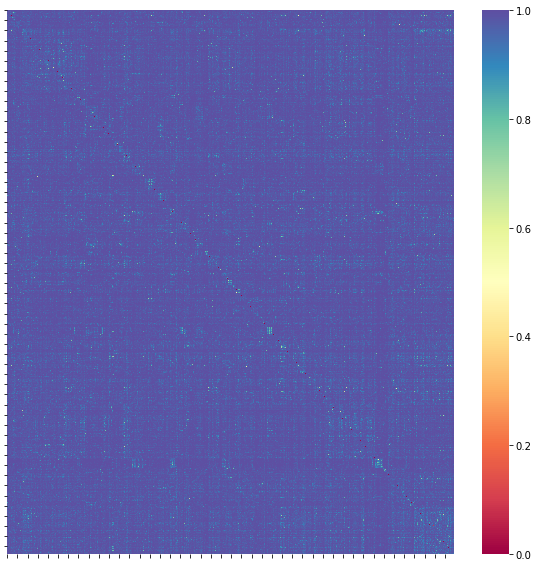

In [22]:
#долго выполняется, лучше не запускать, картинку сохраню, если дождусь
plt.figure(figsize = (10,10))
sns.heatmap(data = S[:5000, :5000], cmap = 'Spectral').set(xticklabels = [],yticklabels = []);

Вообще говоря, это какой то шлак, я ожидал увидеть что-то типа (см картинку ниже). Дальше прогонять нет смысла, тк данные не делятся вообще на кластера, тк ожидалось,  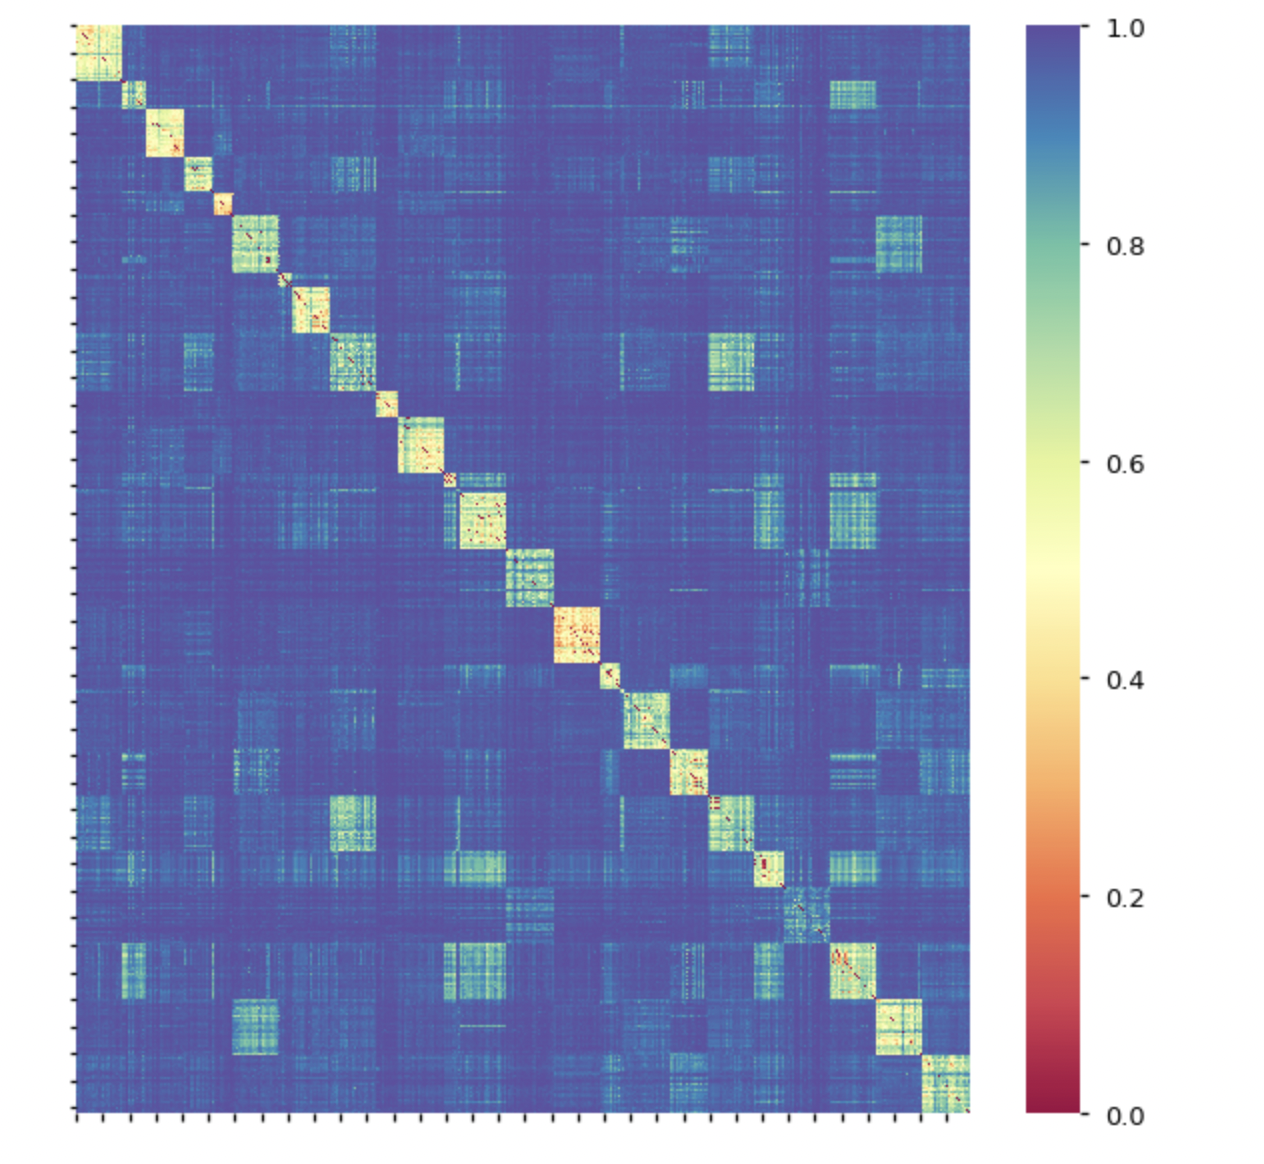

# Кластеризация